In [98]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter
import tensorflow.keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Características a entrenar

In [99]:
#########################################################################
################### ETIQUETAS PARA ENTRENAR LAS REDES ###################
#########################################################################
Etiquetas = {
    "VentajaEspacio" : 0,
    "ColumnasAbiertas" : 1 ,
    "AlfilesMismoColor" : 3,
    "AlfilesDistColor" : 4,
    "ColumnasSemiabiertasB" : 7,
    "PeonesB" : 9,
    "CaballosB" : 10,
    "AlfilesB" : 11,
    "TorresB" : 12,
    "DamasB" : 13,
    "TorreSeptimaB" : 14,
    "TorresDobladasB" : 15,
    "TorresLigadasB" : 16,
    "PistolaAlekhineB" : 17,
    "PeonesDobladosB" : 18,
    "PeonesAisladosB" : 20,
    "PeonesRetrasadosB" : 22,
    "PeonesPasadosB" : 24,
    "IslasPeonesB" : 26,
    "FalangesPeonesB" : 28,
    "PeonesConectadosB" : 30,
    "ColumnasSemiabiertasN" : 34,
    "PeonesN" : 36,
    "CaballosN" : 37,
    "AlfilesN" : 38,
    "TorresN" : 39,
    "DamasN" : 40,
    "TorreSeptimaN" : 41,
    "TorresDobladasN" : 42,
    "TorresLigadasN" : 43,
    "PistolaAlekhineN" : 44,
    "PeonesDobladosN" : 45,
    "PeonesAisladosN" : 47,
    "PeonesRetrasadosN" : 49,
    "PeonesPasadosN" : 51,
    "IslasPeonesN" : 53,
    "FalangesPeonesN" : 55,
    "PeonesConectadosN" : 57
}

# Funciones Auxiliares

In [62]:
#########################################################################
# FUNCIONES PARA CONVERTIR LOS DATASETS A MATRIZ O A ARRAY DE FLOTANTES # 
#########################################################################

def primera_representacion(data):
    """
    Convertimos el dataset con la primera codificación
    a una matriz tridimensional de floats, 7 tableros de 8x8.
    """
    matriz = []
    aux = np.zeros([8,8,7])
    
    for i in range(len(data)):
        for j in range(7):
            t = data[i][j].split(',')
            u = [float(x) for x in t]
            for k in range(8):
                for l in range(8):
                    aux[k][l][j] = u[(8*k+l)]
     
        matriz.append(aux.copy())
    return matriz

def segunda_representacion(data):
    """
    Convertimos el dataset con la primera codificación a un array
    de floats de 448 posiciones, los 7 tableros en un array.
    """
    array = []
    aux = np.zeros(64*7)
    
    for i in range(len(data)):
        for j in range(7):
            t = data[i][j].split(',')
            u = [float(x) for x in t]
            for k in range(64):
                aux[k+j*64] = u[k]
     
        array.append(aux.copy())
    return array

def tercera_representacion(data):
    """
    Convertimos el dataset con la segunda codificación 
    a una matriz.
    """
    
    matriz = []
    aux = np.zeros([8,8,1])
    
    for i in range(len(data)):
        t = data[i][0].split(',')
        u = [float(x) for x in t]
        for k in range(8):
            for l in range(8):
                aux[k][l][0] = u[(8*k+l)]

        matriz.append(aux.copy())
    return matriz

#########################################################################
################ FUNCIÓN PARA LEER EL CONJUNTO DE DATOS #################
#########################################################################
def leer_datos(csv):
    """
    Dado un csv separado por ';' leemos los datos.
    """
    dataset = pd.read_csv(csv, sep=';')
    
    return dataset

#########################################################################
###################### FUNCIÓN PARA EXPORTAR DATOS ######################
#########################################################################
def exportar_datos(dataframe, nombre):
    """
    Dado un dataframe y el nombre que recibe lo exportamos a csv, separado por ';'.
    """
    dataframe.to_csv(nombre, sep=';')

#########################################################################
############## FUNCIONES PARA CARGAR EL CONJUNTO DE DATOS ###############
#########################################################################
def cargar_datos():
    """
    Cargamos los datos, para ello leemos primero los ficheros.
    Posteriormente codificamos los datos de entrada y devolvemos
    los conjuntos de entrenamiento y test para usarlos con keras.
    """
    
    # Leemos los datos
    datasetTablerosPrimeraCod = leer_datos('/content/drive/MyDrive/TFG_Ajedrez/CSV/PrimeraCodificacionTablero.csv')
    datasetTablerosSegundaCod = leer_datos('/content/drive/MyDrive/TFG_Ajedrez/CSV/SegundaCodificacionTablero.csv')
    datasetEtiquetas = leer_datos('/content/drive/MyDrive/TFG_Ajedrez/CSV/Etiquetas.csv')
    
    # Obtenemos los valores que nos interesan
    X_primeraCod = datasetTablerosPrimeraCod.iloc[:, 1:].values
    X_segundaCod = datasetTablerosSegundaCod.iloc[:,1:].values
    Y = datasetEtiquetas.iloc[:, 4:].values

    # Convertimos los datos
    x_train1 = np.array(primera_representacion(X_primeraCod))
    x_train2 = np.array(segunda_representacion(X_primeraCod))
    x_train3 = np.array(tercera_representacion(X_segundaCod))
    
    y_train = Y    
    
    # Dividmos los datos de entrenamiento
    # Primero barajamos los datos y después obtenemos los datos 
    # para los tests y el entrenamiento 
    np.random.seed(100)
    indices = np.random.permutation(x_train1.shape[0])
    valid_cnt = int(x_train1.shape[0]*0.2)

    test_idx, training_idx = indices[:valid_cnt],\
                        indices[valid_cnt:]
    test1, train1 = x_train1[test_idx,:],\
                        x_train1[training_idx]
    test2, train2 = x_train2[test_idx,:],\
                        x_train2[training_idx]
    test3, train3 = x_train3[test_idx,:],\
                        x_train3[training_idx]
    onehot_test, onehot_train = y_train[test_idx,:],\
                        y_train[training_idx,:]
    
    
    
    return train1, test1, train2, test2, train3, test3, onehot_train, onehot_test
    

#########################################################################
################## FUNCIÓN PARA MODIFICAR LAS ETIQUETAS #################
#########################################################################    
def modif_etiquetas(onehot_train, onehot_test, num):
    """
    Es necesario pasarle como parámetros las etiquetas de entrenamiento y
    las etiquetas para el test, asdemás también necesitamos el número de
    la etiqueta seleccionada.
    """
    categorias = max(len(Counter(onehot_train[:,num].reshape(-1))), 
                     len(Counter(onehot_test[:,num].reshape(-1))))
    train_labels = to_categorical(onehot_train[:,num], categorias)
    test_labels = to_categorical(onehot_test[:,num], categorias)
    
    return train_labels, test_labels


#########################################################################
############# FUNCIÓN PARA MOSTRAR LA EVOLUCIÓN DEL MODELO ##############
#########################################################################
def mostrar_evolucion(hist):
    """
    Esta función pinta dos gráficas, una con la evolución
    de la función de pérdida en el conjunto de entrenamiento y
    en el de validación, y otra con la evolución de la
    accuracy en el conjunto de entrenamiento y el de validación.
    Es necesario pasarle como parámetro el historial del
    entrenamiento del modelo.
    """
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Definimos los modelos

In [6]:
def modelo1(input_size, output_size):
    """
    Este modelo toma como entrada una matriz tridimensional 
    formada por 7 tableros. Empleamos una red convolucional para ello.
    """
    # Creamos la estructura que contendrá nuestro modelo
    model = Sequential()
    
    # Creamos las capas ocultas
    model.add(Conv2D(64, kernel_size=(3, 3), input_shape=input_size, activation='relu'))
    # Reducimos la profundidad
    model.add(Conv2D(64, kernel_size=(1, 1), activation='relu'))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(16, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(units = output_size, activation = 'softmax'))
    
    return model    

In [7]:
def modelo2(input_size, output_size):
    """
    Este modelo toma como entrada un array formado por los 7 tableros.
    """
    
    # Creamos la estructura que contendrá nuestro modelo
    model = Sequential()
    
    # Creamos las capas ocultas
    model.add(Dense(128, input_dim = input_size, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(128, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(128, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(16, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(units = output_size, activation = 'softmax'))
    
    return model

In [8]:
def modelo3(input_size, output_size):
    """
    Este modelo cuenta con una codificación de un único tablero 
    con las piezas codificadas con enteros del 1 al 6, positivos
    para las piezas blancas y negativos para las negras, el 0
    significa casilla vacía.
    """
    
    # Creamos la estructura que contendrá nuestro modelo
    model = Sequential()
    
    # Creamos las capas ocultas
    model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_size, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(128, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(128, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(16, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(units = output_size, activation = 'softmax'))
    
    return model

# Entrenamos y evaluamos los modelos

In [9]:
def entrenar_evaluar(model, x_train, y_train, x_test, y_test, batch_size, epochs, validation_split=None, verbose=0, show=False):
    """
    Definimos la función para entrenar y evaluar el modelo.
    Los parámetros necesarios son el modelo a entrenar y evaluar,
    los datos de entrenamiento y las etiquetas, tamaño del batch, 
    las épocas de entrenamiento, el porcentaje de división de los datos, 
    si mostramos o no la progresión y la evolución.
    """    
    # Configuramos el modelo con la función de pérdida, optimizador y métrica
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Entrenamos el modelo
    history = model.fit(x_train, y_train, 
                        epochs=epochs, batch_size=batch_size, 
                        validation_split=validation_split, 
                        callbacks = [tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=16, restore_best_weights=True)], 
                        verbose=verbose)
    

    y_pred = model.predict(x_test, batch_size=batch_size, verbose=verbose)  
    y_predicted = np.argmax(y_pred, axis=1)  
    print(confusion_matrix(y_test.argmax(1), y_predicted))

    print(classification_report(np.argmax(y_test, axis=1), y_predicted))
    f1_m = f1_score(np.argmax(y_test, axis=1), y_predicted, average='macro')
    print(f1_m)
    f1_w = f1_score(np.argmax(y_test, axis=1), y_predicted, average='weighted')
    print(f1_w)

    # Evaluamos el modelo
    score = model.evaluate(x_test, y_test, verbose=verbose)
    
    print(score)
    
    if show == True:
        mostrar_evolucion(history)

    return model.get_weights(), score[0], score[1], f1_m, f1_w

# Realizamos los entrenamientos 

## Obtenemos los datos

In [10]:
train1, test1, train2, test2, train3, test3, onehot_train, onehot_test = cargar_datos()

In [11]:
# Número de etiquetas
len(Counter(Etiquetas))

38

In [12]:
# Almacenamos las etiquetas como datos categóricos 

y_train = []
y_test = []

for e in Etiquetas.values():
    train_labels, test_labels = modif_etiquetas(onehot_train,onehot_test,e)
    y_train.append(np.array(train_labels.copy()))
    y_test.append(np.array(test_labels.copy()))

In [13]:
for i in range(len(Counter(Etiquetas))):
    print(i,": ",y_train[i].shape, y_test[i].shape)

0 :  (40000, 3) (10000, 3)
1 :  (40000, 8) (10000, 8)
2 :  (40000, 2) (10000, 2)
3 :  (40000, 2) (10000, 2)
4 :  (40000, 7) (10000, 7)
5 :  (40000, 9) (10000, 9)
6 :  (40000, 3) (10000, 3)
7 :  (40000, 3) (10000, 3)
8 :  (40000, 3) (10000, 3)
9 :  (40000, 3) (10000, 3)
10 :  (40000, 2) (10000, 2)
11 :  (40000, 2) (10000, 2)
12 :  (40000, 2) (10000, 2)
13 :  (40000, 2) (10000, 2)
14 :  (40000, 4) (10000, 4)
15 :  (40000, 7) (10000, 7)
16 :  (40000, 5) (10000, 5)
17 :  (40000, 7) (10000, 7)
18 :  (40000, 5) (10000, 5)
19 :  (40000, 4) (10000, 4)
20 :  (40000, 4) (10000, 4)
21 :  (40000, 7) (10000, 7)
22 :  (40000, 9) (10000, 9)
23 :  (40000, 3) (10000, 3)
24 :  (40000, 3) (10000, 3)
25 :  (40000, 3) (10000, 3)
26 :  (40000, 3) (10000, 3)
27 :  (40000, 2) (10000, 2)
28 :  (40000, 2) (10000, 2)
29 :  (40000, 2) (10000, 2)
30 :  (40000, 2) (10000, 2)
31 :  (40000, 4) (10000, 4)
32 :  (40000, 7) (10000, 7)
33 :  (40000, 5) (10000, 5)
34 :  (40000, 7) (10000, 7)
35 :  (40000, 5) (10000, 5)
36

## Modelo 1

In [ ]:
# Tamaño del batch
batch_size = 32
# Épocas de entrenamiento
epochs = 80
# División de los datos
validation_split = 0.2
# Progresión
verbose = 1
# Mostrar Evolucion
show = True

In [ ]:
# Definimos el array de pesos, la media de la función pérdida y la media de accuracy
arr_weights1 = []
weights1 = 0
arr_loss1 = []
mean_loss1 = 0
loss1 = 0
arr_acc1 = []
mean_acc1 = 0
acc1 = 0
f1_macro1 = 0
f1_weighted1 = 0
arr_f1_macro1 = []
arr_f1_weighted1 = []

Número :  0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 6, 64)          4096      
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 64)          4160      
                                                                 
 dropout (Dropout)           (None, 6, 6, 64)          0         
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 64)                147520    
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                            

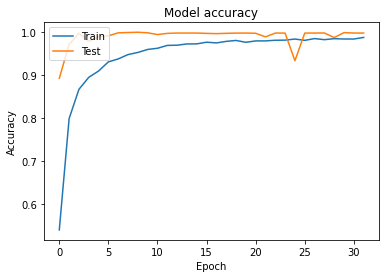

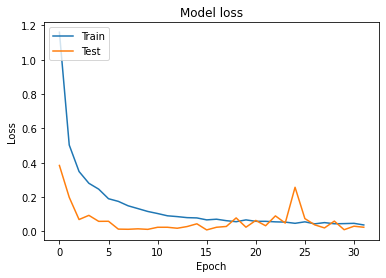

Número :  1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          4096      
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 64)          4160      
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_5 (Dense)             (None, 64)                147520    
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                          

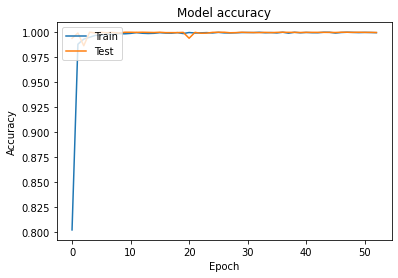

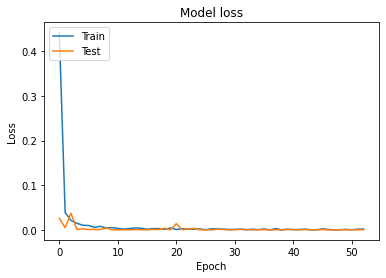

Número :  2
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 6, 6, 64)          4096      
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 64)          4160      
                                                                 
 dropout_2 (Dropout)         (None, 6, 6, 64)          0         
                                                                 
 flatten_2 (Flatten)         (None, 2304)              0         
                                                                 
 dense_10 (Dense)            (None, 64)                147520    
                                                                 
 batch_normalization_8 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                          

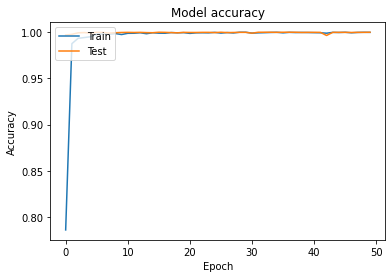

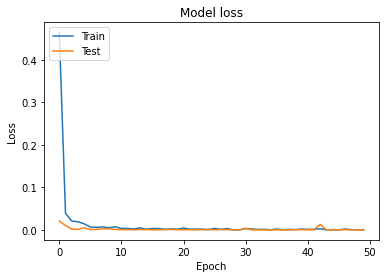

Número :  3
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 6, 6, 64)          4096      
                                                                 
 conv2d_7 (Conv2D)           (None, 6, 6, 64)          4160      
                                                                 
 dropout_3 (Dropout)         (None, 6, 6, 64)          0         
                                                                 
 flatten_3 (Flatten)         (None, 2304)              0         
                                                                 
 dense_15 (Dense)            (None, 64)                147520    
                                                                 
 batch_normalization_12 (Bat  (None, 64)               256       
 chNormalization)                                                
                                          

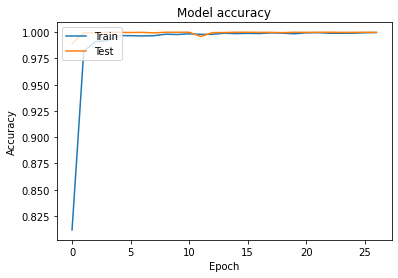

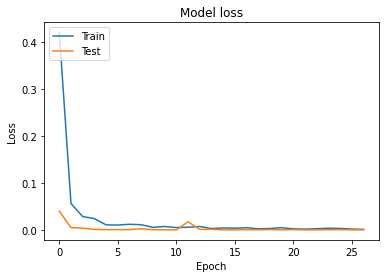

Número :  4
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 6, 6, 64)          4096      
                                                                 
 conv2d_9 (Conv2D)           (None, 6, 6, 64)          4160      
                                                                 
 dropout_4 (Dropout)         (None, 6, 6, 64)          0         
                                                                 
 flatten_4 (Flatten)         (None, 2304)              0         
                                                                 
 dense_20 (Dense)            (None, 64)                147520    
                                                                 
 batch_normalization_16 (Bat  (None, 64)               256       
 chNormalization)                                                
                                          

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 4ms/step - loss: 0.0011 - accuracy: 0.9998
[0.0011142498115077615, 0.9998000264167786]


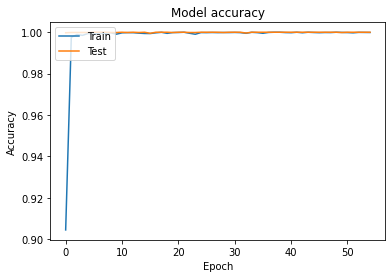

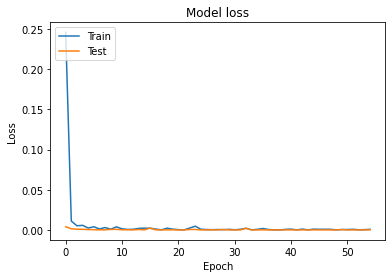

Número :  5
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 6, 6, 64)          4096      
                                                                 
 conv2d_11 (Conv2D)          (None, 6, 6, 64)          4160      
                                                                 
 dropout_5 (Dropout)         (None, 6, 6, 64)          0         
                                                                 
 flatten_5 (Flatten)         (None, 2304)              0         
                                                                 
 dense_25 (Dense)            (None, 64)                147520    
                                                                 
 batch_normalization_20 (Bat  (None, 64)               256       
 chNormalization)                                                
                                          

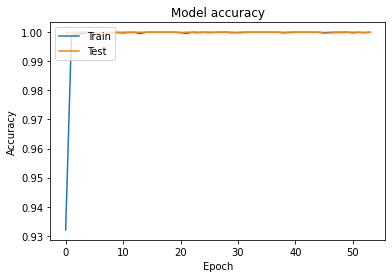

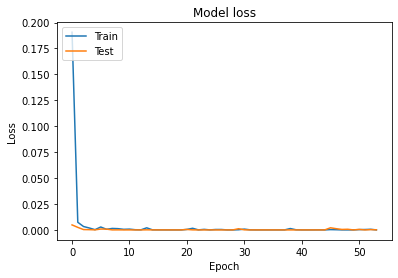

Número :  6
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 6, 6, 64)          4096      
                                                                 
 conv2d_13 (Conv2D)          (None, 6, 6, 64)          4160      
                                                                 
 dropout_6 (Dropout)         (None, 6, 6, 64)          0         
                                                                 
 flatten_6 (Flatten)         (None, 2304)              0         
                                                                 
 dense_30 (Dense)            (None, 64)                147520    
                                                                 
 batch_normalization_24 (Bat  (None, 64)               256       
 chNormalization)                                                
                                          

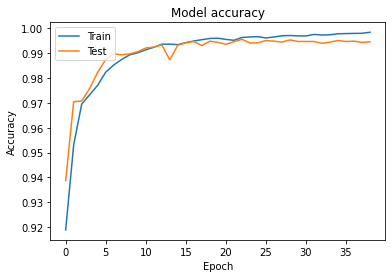

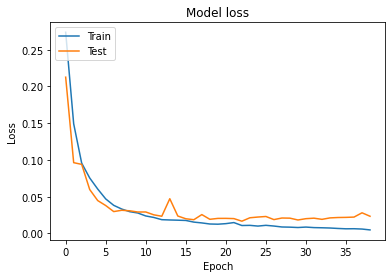

Número :  7
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 6, 6, 64)          4096      
                                                                 
 conv2d_15 (Conv2D)          (None, 6, 6, 64)          4160      
                                                                 
 dropout_7 (Dropout)         (None, 6, 6, 64)          0         
                                                                 
 flatten_7 (Flatten)         (None, 2304)              0         
                                                                 
 dense_35 (Dense)            (None, 64)                147520    
                                                                 
 batch_normalization_28 (Bat  (None, 64)               256       
 chNormalization)                                                
                                          

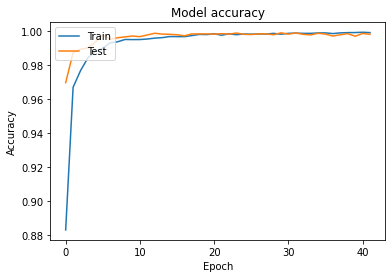

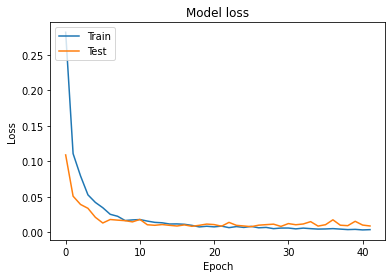

Número :  8
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 6, 6, 64)          4096      
                                                                 
 conv2d_17 (Conv2D)          (None, 6, 6, 64)          4160      
                                                                 
 dropout_8 (Dropout)         (None, 6, 6, 64)          0         
                                                                 
 flatten_8 (Flatten)         (None, 2304)              0         
                                                                 
 dense_40 (Dense)            (None, 64)                147520    
                                                                 
 batch_normalization_32 (Bat  (None, 64)               256       
 chNormalization)                                                
                                          

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 4ms/step - loss: 0.0033 - accuracy: 0.9997
[0.003319863462820649, 0.9997000098228455]


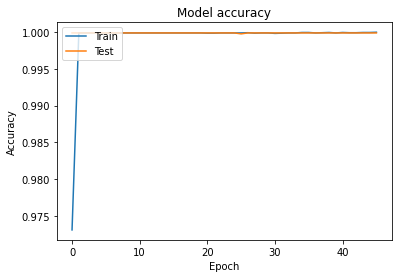

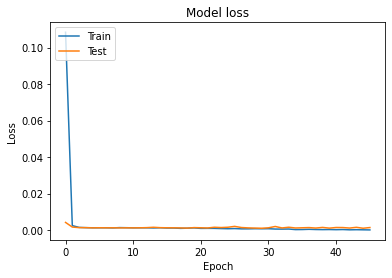

Número :  9
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 6, 6, 64)          4096      
                                                                 
 conv2d_19 (Conv2D)          (None, 6, 6, 64)          4160      
                                                                 
 dropout_9 (Dropout)         (None, 6, 6, 64)          0         
                                                                 
 flatten_9 (Flatten)         (None, 2304)              0         
                                                                 
 dense_45 (Dense)            (None, 64)                147520    
                                                                 
 batch_normalization_36 (Bat  (None, 64)               256       
 chNormalization)                                                
                                          

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 4ms/step - loss: 0.0318 - accuracy: 0.9943
[0.031808000057935715, 0.9943000078201294]


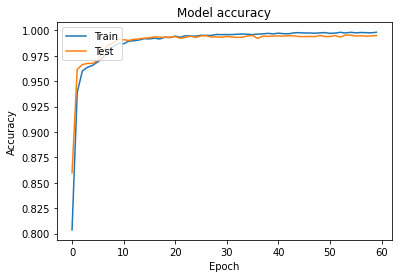

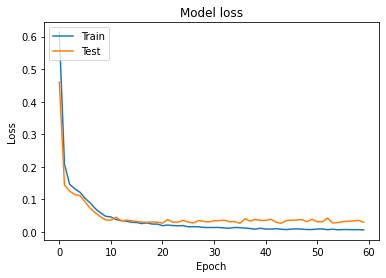

Número :  10
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 6, 6, 64)          4096      
                                                                 
 conv2d_21 (Conv2D)          (None, 6, 6, 64)          4160      
                                                                 
 dropout_10 (Dropout)        (None, 6, 6, 64)          0         
                                                                 
 flatten_10 (Flatten)        (None, 2304)              0         
                                                                 
 dense_50 (Dense)            (None, 64)                147520    
                                                                 
 batch_normalization_40 (Bat  (None, 64)               256       
 chNormalization)                                                
                                        

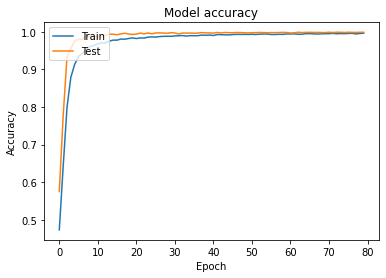

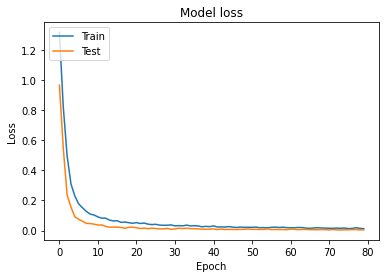

Número :  11
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 6, 6, 64)          4096      
                                                                 
 conv2d_23 (Conv2D)          (None, 6, 6, 64)          4160      
                                                                 
 dropout_11 (Dropout)        (None, 6, 6, 64)          0         
                                                                 
 flatten_11 (Flatten)        (None, 2304)              0         
                                                                 
 dense_55 (Dense)            (None, 64)                147520    
                                                                 
 batch_normalization_44 (Bat  (None, 64)               256       
 chNormalization)                                                
                                        

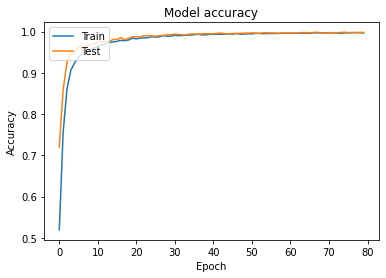

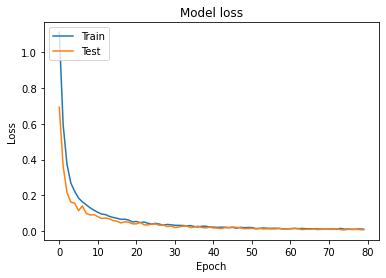

Número :  12
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 6, 6, 64)          4096      
                                                                 
 conv2d_25 (Conv2D)          (None, 6, 6, 64)          4160      
                                                                 
 dropout_12 (Dropout)        (None, 6, 6, 64)          0         
                                                                 
 flatten_12 (Flatten)        (None, 2304)              0         
                                                                 
 dense_60 (Dense)            (None, 64)                147520    
                                                                 
 batch_normalization_48 (Bat  (None, 64)               256       
 chNormalization)                                                
                                        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 2s 4ms/step - loss: 0.0138 - accuracy: 0.9957
[0.013834591954946518, 0.9957000017166138]


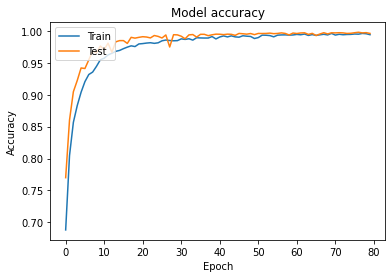

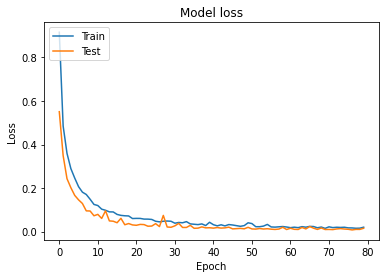

Número :  13
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 6, 6, 64)          4096      
                                                                 
 conv2d_27 (Conv2D)          (None, 6, 6, 64)          4160      
                                                                 
 dropout_13 (Dropout)        (None, 6, 6, 64)          0         
                                                                 
 flatten_13 (Flatten)        (None, 2304)              0         
                                                                 
 dense_65 (Dense)            (None, 64)                147520    
                                                                 
 batch_normalization_52 (Bat  (None, 64)               256       
 chNormalization)                                                
                                        

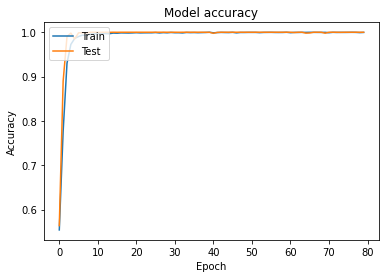

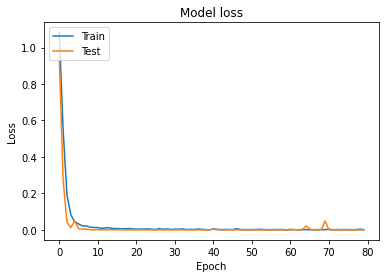

Número :  14
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 6, 6, 64)          4096      
                                                                 
 conv2d_29 (Conv2D)          (None, 6, 6, 64)          4160      
                                                                 
 dropout_14 (Dropout)        (None, 6, 6, 64)          0         
                                                                 
 flatten_14 (Flatten)        (None, 2304)              0         
                                                                 
 dense_70 (Dense)            (None, 64)                147520    
                                                                 
 batch_normalization_56 (Bat  (None, 64)               256       
 chNormalization)                                                
                                        

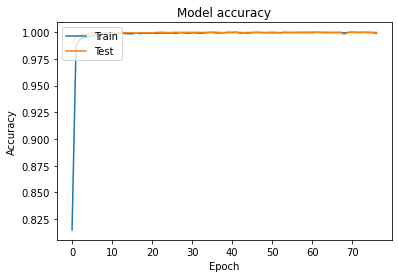

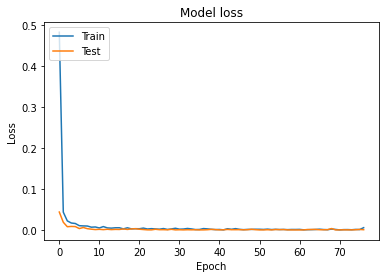

Número :  15
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 6, 6, 64)          4096      
                                                                 
 conv2d_31 (Conv2D)          (None, 6, 6, 64)          4160      
                                                                 
 dropout_15 (Dropout)        (None, 6, 6, 64)          0         
                                                                 
 flatten_15 (Flatten)        (None, 2304)              0         
                                                                 
 dense_75 (Dense)            (None, 64)                147520    
                                                                 
 batch_normalization_60 (Bat  (None, 64)               256       
 chNormalization)                                                
                                        

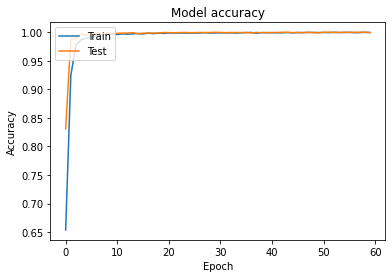

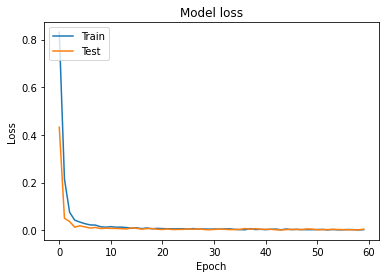

Número :  16
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 6, 6, 64)          4096      
                                                                 
 conv2d_33 (Conv2D)          (None, 6, 6, 64)          4160      
                                                                 
 dropout_16 (Dropout)        (None, 6, 6, 64)          0         
                                                                 
 flatten_16 (Flatten)        (None, 2304)              0         
                                                                 
 dense_80 (Dense)            (None, 64)                147520    
                                                                 
 batch_normalization_64 (Bat  (None, 64)               256       
 chNormalization)                                                
                                        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 2s 4ms/step - loss: 0.0074 - accuracy: 0.9979
[0.007356859743595123, 0.9979000091552734]


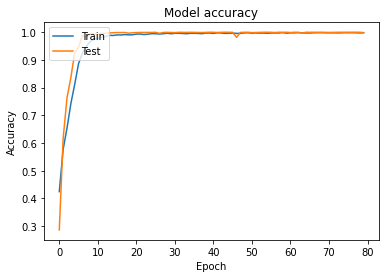

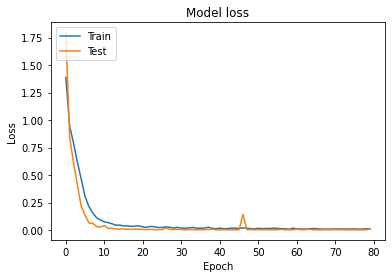

Número :  17
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 6, 6, 64)          4096      
                                                                 
 conv2d_35 (Conv2D)          (None, 6, 6, 64)          4160      
                                                                 
 dropout_17 (Dropout)        (None, 6, 6, 64)          0         
                                                                 
 flatten_17 (Flatten)        (None, 2304)              0         
                                                                 
 dense_85 (Dense)            (None, 64)                147520    
                                                                 
 batch_normalization_68 (Bat  (None, 64)               256       
 chNormalization)                                                
                                        

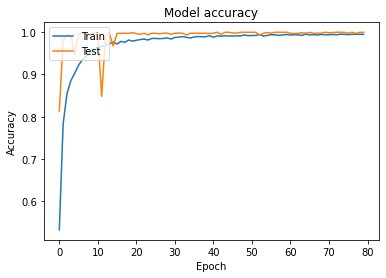

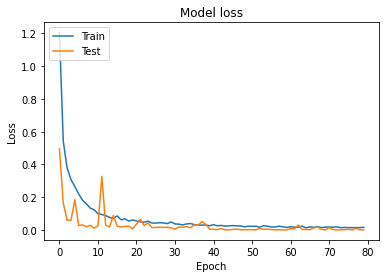

Número :  18
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 6, 6, 64)          4096      
                                                                 
 conv2d_37 (Conv2D)          (None, 6, 6, 64)          4160      
                                                                 
 dropout_18 (Dropout)        (None, 6, 6, 64)          0         
                                                                 
 flatten_18 (Flatten)        (None, 2304)              0         
                                                                 
 dense_90 (Dense)            (None, 64)                147520    
                                                                 
 batch_normalization_72 (Bat  (None, 64)               256       
 chNormalization)                                                
                                        

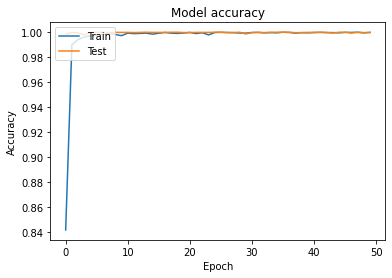

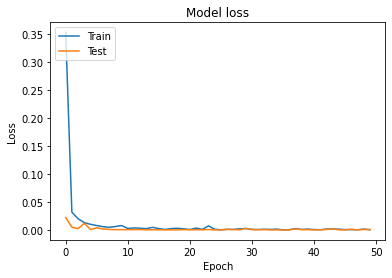

Número :  19
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 6, 6, 64)          4096      
                                                                 
 conv2d_39 (Conv2D)          (None, 6, 6, 64)          4160      
                                                                 
 dropout_19 (Dropout)        (None, 6, 6, 64)          0         
                                                                 
 flatten_19 (Flatten)        (None, 2304)              0         
                                                                 
 dense_95 (Dense)            (None, 64)                147520    
                                                                 
 batch_normalization_76 (Bat  (None, 64)               256       
 chNormalization)                                                
                                        

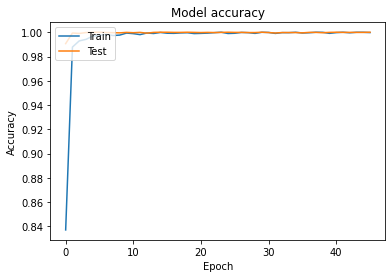

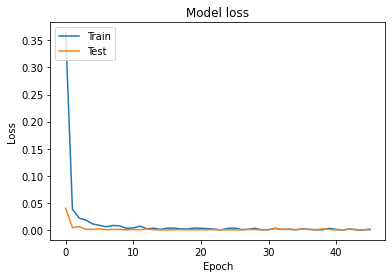

Número :  20
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 6, 6, 64)          4096      
                                                                 
 conv2d_41 (Conv2D)          (None, 6, 6, 64)          4160      
                                                                 
 dropout_20 (Dropout)        (None, 6, 6, 64)          0         
                                                                 
 flatten_20 (Flatten)        (None, 2304)              0         
                                                                 
 dense_100 (Dense)           (None, 64)                147520    
                                                                 
 batch_normalization_80 (Bat  (None, 64)               256       
 chNormalization)                                                
                                        

In [ ]:
for i in range(len(Counter(Etiquetas))):
    print("Número : ",i)
    model = modelo1(train1[i].shape, y_train[i].shape[1])
    model.summary()
    weights1, loss1, acc1, f1_macro1, f1_weighted1 = entrenar_evaluar(model, train1, y_train[i], test1, y_test[i], batch_size, epochs, validation_split, verbose, show)
    arr_weights1.append(weights1)
    arr_loss1.append(loss1)
    arr_acc1.append(acc1)
    arr_f1_macro1.append(f1_macro1)
    arr_f1_weighted1.append(f1_weighted1)
    mean_loss1 = mean_loss1 + loss1
    mean_acc1 = mean_acc1 + acc1

mean_loss1 = mean_loss1/len(Counter(Etiquetas))
mean_acc1 = mean_acc1/len(Counter(Etiquetas))

In [ ]:
lista_m1 = [arr_loss1,arr_acc1,arr_f1_macro1,arr_f1_weighted1]

df_1 = pd.DataFrame(lista_m1)
exportar_datos(df_1, 'model1.csv')

In [ ]:
from google.colab import files
files.download("model1.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Modelo 2

In [ ]:
# Tamaño del batch
batch_size = 32
# Épocas de entrenamiento
epochs = 150
# División de los datos
validation_split = 0.2
# Progresión
verbose = 1
# Mostrar Evolucion
show = True

In [ ]:
# Definimos el array de pesos, la media de la función pérdida y la media de accuracy
arr_weights2 = []
weights2 = 0
arr_loss2 = []
mean_loss2 = 0
loss2 = 0
arr_acc2 = []
mean_acc2 = 0
acc2 = 0
f1_macro2 = 0
f1_weighted2 = 0
arr_f1_macro2 = []
arr_f1_weighted2 = []

In [ ]:
for i in range(len(Counter(Etiquetas))):
    print("Número : ",i)
    model = modelo2(train2.shape[1], y_train[i].shape[1])
    model.summary()
    weights2, loss2, acc2, f1_macro2, f1_weighted2 = entrenar_evaluar(model, train2, y_train[i], test2, y_test[i], batch_size, epochs, validation_split, verbose, show)
    arr_weights2.append(weights2)
    arr_loss2.append(loss2)
    arr_acc2.append(acc2)
    arr_f1_macro2.append(f1_macro2)
    arr_f1_weighted2.append(f1_weighted2)
    mean_loss2 = mean_loss2 + loss2
    mean_acc2 = mean_acc2 + acc2

mean_loss2 = mean_loss2/len(Counter(Etiquetas))
mean_acc2 = mean_acc2/len(Counter(Etiquetas))

Número :  0
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_144 (Dense)           (None, 128)               57472     
                                                                 
 batch_normalization_128 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                                 
 dense_145 (Dense)           (None, 64)                8256      
                                                                 
 batch_normalization_129 (Ba  (None, 64)               256       
 tchNormalization)                                               
                                                                 
 dense_146 (Dense)           (None, 128)               8320      
                                                                 
 batch_normalization_130 (Ba  (None, 128)

KeyboardInterrupt: ignored

In [ ]:
lista_m2 = [arr_loss2,arr_acc2,arr_f1_macro2,arr_f1_weighted2]

df_2 = pd.DataFrame(lista_m2)
exportar_datos(df_2, 'model2.csv')

In [ ]:
from google.colab import files
files.download("model2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Modelo 3

In [14]:
# Tamaño del batch
batch_size = 32
# Épocas de entrenamiento
epochs = 100
# División de los datos
validation_split = 0.2
# Progresión
verbose = 1
# Mostrar Evolucion
show = True

In [15]:
# Definimos el array de pesos, la media de la función pérdida y la media de accuracy
arr_weights3 = []
weights3 = 0
arr_loss3 = []
mean_loss3 = 0
loss3 = 0
arr_acc3 = []
mean_acc3 = 0
acc3 = 0
f1_macro3 = 0
f1_weighted3 = 0
arr_f1_macro3 = []
arr_f1_weighted3 = []

In [ ]:
for i in range(len(Counter(Etiquetas))):
    print("Número : ",i)
    model = modelo3(train3[i].shape, y_train[i].shape[1])
    model.summary()
    weights3, loss3, acc3, f1_macro3, f1_weighted3 = entrenar_evaluar(model, train3, y_train[i], test3, y_test[i], batch_size, epochs, validation_split, verbose, show)
    arr_weights3.append(weights3)
    arr_loss3.append(loss3)
    arr_acc3.append(acc3)
    arr_f1_macro3.append(f1_macro3)
    arr_f1_weighted3.append(f1_weighted3)
    mean_loss3 = mean_loss3 + loss3
    mean_acc3 = mean_acc3 + acc3

mean_loss3 = mean_loss3/len(Counter(Etiquetas))
mean_acc3 = mean_acc3/len(Counter(Etiquetas))

Número :  0
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          320       
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 32)          0         
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 dense_9 (Dense)             (None, 64)                73792     
                                                                 
 batch_normalization_8 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                          

In [ ]:
lista_m3 = [arr_loss3,arr_acc3,arr_f1_macro3,arr_f1_weighted3]

df_3 = pd.DataFrame(lista_m3)
exportar_datos(df_3, 'model3.csv')

In [ ]:
from google.colab import files
files.download("model3.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>